In [1]:
import librosa
import librosa.display
import numpy as np
import soundfile as sf
import IPython
from PIL import Image
from tqdm import trange
import random

import matplotlib.pyplot as plt
%matplotlib inline

Find sample sounds [here](https://librosa.org/doc/main/recordings.html):

|`key`|full name|description|
|-|-|-|
| brahms | Brahms - Hungarian Dance #5 |  A short performance of this piece, with soft note onsets and variable tempo.|
| choice | Admiral Bob - Choice | A short drum and bass loop, good for demonstrating decomposition methods.| 
| fishin | Karissa Hobbs - Let’s Go Fishin’ |  A folk/pop song with verse/chorus/verse structure and vocals.|
| nutcracker | Tchaikovsky - Dance of the Sugar Plum Fairy | Orchestral piece included to demonstrate tempo and harmony features.|
| trumpet | Mihai Sorohan - Trumpet loop | Monophonic trumpet recording, good for demonstrating pitch features. |
| vibeace | Kevin Macleod - Vibe Ace | A vibraphone, piano, and bass combo. Previously the only included example.|

In [2]:
def get_example(key):
  filename = librosa.ex(key)
  data, samplerate = sf.read(filename, dtype='float32')
  data = data.T
  data_22k = librosa.resample(data, samplerate, 22050)
  return data_22k, 22050  

In [3]:
data, sr = get_example("choice")
IPython.display.Audio(data = data, rate = sr)

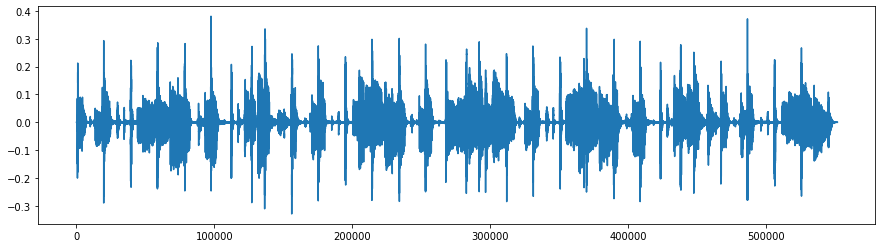

In [4]:
plt.figure(figsize = (15, 4))
plt.plot(data)

In [42]:
# sf.write("./5s.wav", data[:sr * 5], sr)
IPython.display.Audio(data = data[:sr * 5], rate = sr)

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# http://man.hubwiz.com/docset/LibROSA.docset/Contents/Resources/Documents/tutorial.html
# beat_track

# - tempo: estimate of the tempo (in beats per minute)
# - beat_frames: frame numbers corresponding to detected beat events.
#                Frames here correspond to short windows of the signal
#                each separated by `hop_length`.
#                so that the kth frame is centered around sample `k*hop_length`
tempo, beat_frames = librosa.beat.beat_track(y=data, sr=sr)
print("--beat_frames",beat_frames)

# beat_times: Array of timestamps (in seconds) corresponding to detected beat events
beat_times = librosa.frames_to_time(beat_frames, sr=sr)
print("--beat_times",beat_times)

# harmonics  (tonal) and precursive (transient) [more below]
y_harmonic, y_percussive = librosa.effects.hpss(data)
print(y_harmonic.shape, y_percussive.shape)

--beat_frames [   3   21   40   59   78   96  116  135  154  173  192  211  230  249
  268  287  306  325  344  363  382  401  420  439  458  476  495  515
  534  553  572  591  610  629  647  667  686  705  724  743  762  780
  799  819  838  857  876  895  914  933  951  971  990 1008]
--beat_times [ 0.06965986  0.48761905  0.92879819  1.36997732  1.81115646  2.22911565
  2.69351474  3.13469388  3.57587302  4.01705215  4.45823129  4.89941043
  5.34058957  5.78176871  6.22294785  6.66412698  7.10530612  7.54648526
  7.9876644   8.42884354  8.87002268  9.31120181  9.75238095 10.19356009
 10.63473923 11.05269841 11.49387755 11.95827664 12.39945578 12.84063492
 13.28181406 13.7229932  14.16417234 14.60535147 15.02331066 15.48770975
 15.92888889 16.37006803 16.81124717 17.2524263  17.69360544 18.11156463
 18.55274376 19.01714286 19.458322   19.89950113 20.34068027 20.78185941
 21.22303855 21.66421769 22.08217687 22.54657596 22.9877551  23.40571429]
(551823,) (551823,)


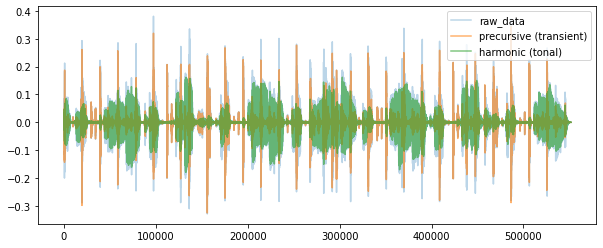

In [6]:
plt.figure(figsize = (10, 4))
plt.plot(data, alpha = 0.3)
plt.plot(y_percussive, alpha = 0.6)
plt.plot(y_harmonic, alpha = 0.6)
plt.legend(("raw_data", "precursive (transient)", "harmonic (tonal)"))

**Beat:** is an interference pattern between two frequencies, percieved as a preiodic variation on volume whose rate is difference between two frequencies. As you can see in the GIF below, as the green wave moves over the red wave, the final output (blue wave) changes in frequency and amplitude.

<img src="https://upload.wikimedia.org/wikipedia/commons/e/eb/WaveInterference.gif">

**Precursive:** or as the name suggests are high amplitude, short duration sound at the beginning of a waveform. They are not necesarily dependent on the frequencies that they initiate.

**Tonal:** They are sounds that have a regular vibration. In the image below, the Steady-state phase is the tonal while the transient phase is the precursive.

<img src="https://www.spacegass.com/manual/ResponsePhases.png">

The motivation for this kind of operation is two-fold: first, percussive elements tend to be stronger indicators of rhythmic content, and can help provide more stable beat tracking results; second, percussive elements can pollute tonal feature representations (such as chroma) by contributing energy across all frequency bands, so we’d be better off without them.

In [7]:
import IPython.display as ipd
ipd.Audio(data = y_harmonic, rate = sr)

In [8]:
ipd.Audio(data = y_percussive, rate = sr)

--mfcc.shape: (8, 1078)


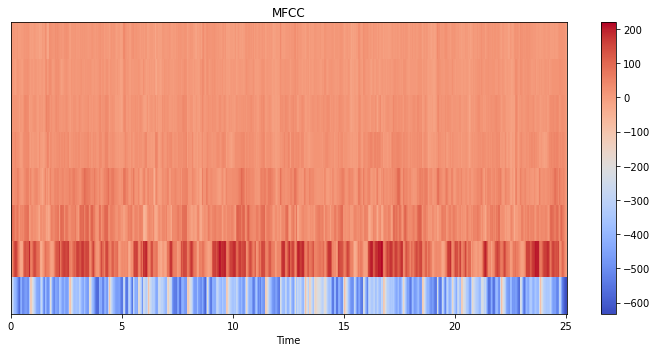

In [10]:
# Mel-frequency cepstral coefficients from the raw signal
# mfcc: [n_mfcc, T] -> T is the track duration in frames
hop_length = 512
mfcc = librosa.feature.mfcc(y=data, sr=sr, hop_length=hop_length, n_mfcc=8)
print("--mfcc.shape:",mfcc.shape)
plt.figure(figsize = (10, 5))
librosa.display.specshow(mfcc, x_axis = "time")
plt.colorbar()
plt.title("MFCC")
plt.tight_layout()

--mfcc_delta.shape: (8, 1078)


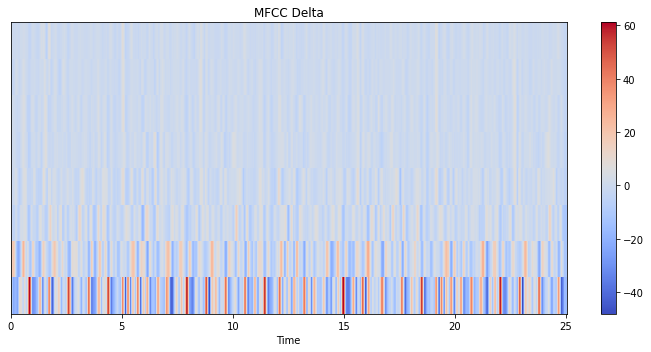

In [11]:
mfcc_delta = librosa.feature.delta(mfcc) # first order differences
print("--mfcc_delta.shape:",mfcc_delta.shape)
plt.figure(figsize = (10, 5))
librosa.display.specshow(mfcc_delta, x_axis = "time")
plt.colorbar()
plt.title("MFCC Delta")
plt.tight_layout()

The chroma has 12 rows, each standing for one pitch. Take a look at this table for reference.


| Pitch Class | Tonal Counterparts | Solfege | Bhartiya [स्वर](https://en.wikipedia.org/wiki/Svara) |
|-|-|-|-|
|0|	C (also B♯, Ddouble flat)	| do| सा |
|1|	C♯, D♭ (also Bdouble sharp)	| | |
|2|	D (also Cdouble sharp, Edouble flat)	| re| रे |
|3|	D♯, E♭ (also Fdouble flat)	| | |
|4|	E (also Ddouble sharp, F♭)	| mi| गा |
|5|	F (also E♯, Gdouble flat)	| fa| म |
|6|	F♯, G♭ (also Edouble sharp)	| | |
|7|	G (also Fdouble sharp, Adouble flat)	| sol| प |
|8|	G♯, A♭	| | |
|9|	A (also Gdouble sharp, Bdouble flat)	| la| ध |
|10|A♯, B♭ (also Cdouble flat)	| | |
|11|B (also Adouble sharp, C♭)	| si| नी |

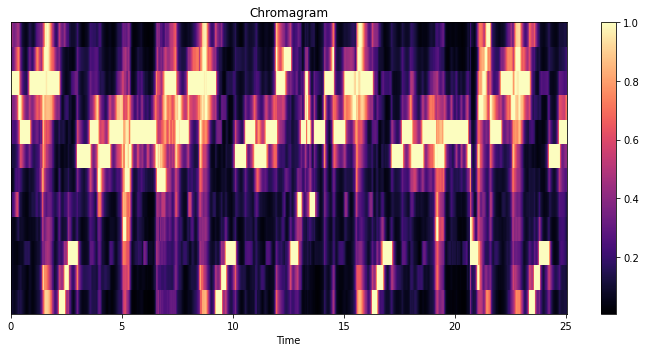

In [12]:
# each row of the chromagram corresponds to a pitch class
# the column values are normalised by peak
#   disable by passing norm = None
chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr)
plt.figure(figsize = (10, 5))
librosa.display.specshow(chromagram, x_axis = "time")
plt.colorbar()
plt.title("Chromagram")
plt.tight_layout()

In order to create the frames `librosa` pads the values as you can see in the `chromagram` shape below. 

In [13]:
chromagram.shape[1] * 512, len(data)

(551936, 551823)

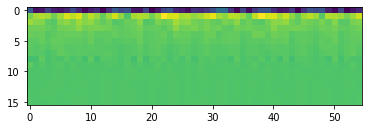

In [14]:
# Each column `beat_mfcc_delta[:, k]` will be the average of
# input columns between `beat_frames[k]` and `beat_frames[k+1]`.
# (beat_frames will be expanded to span the full range [0, T]
# so that all data is accounted for.)
beat_mfcc_delta = librosa.util.sync(
  np.vstack([mfcc, mfcc_delta]),
  beat_frames
)
plt.imshow(beat_mfcc_delta)

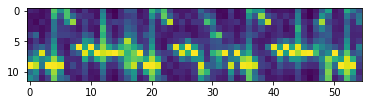

In [15]:
beat_chroma = librosa.util.sync(
  chromagram, beat_frames, aggregate=np.mean
)
plt.imshow(beat_chroma)

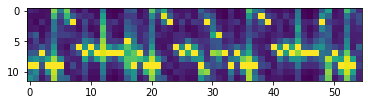

In [16]:
beat_chroma = librosa.util.sync(
  chromagram, beat_frames, aggregate=np.median
)
plt.imshow(beat_chroma)

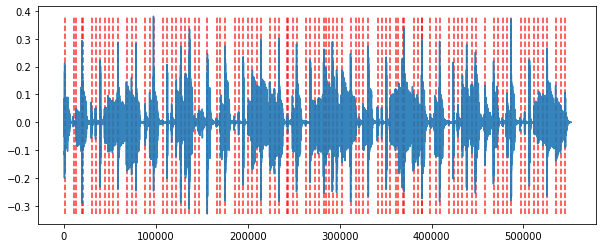

In [17]:
onset_frames = librosa.onset.onset_detect(y=data)
onset_times = librosa.frames_to_time(onset_frames, sr=sr)
onset_times = onset_times * sr
plt.figure(figsize = (10, 4))
plt.plot(data, alpha = 0.9)
plt.vlines(onset_times, data.min(), data.max(), color = 'r', linestyle = '--', alpha = 0.8)

### Creation of Latents

From the above analysis is this is what I think is the appropriate method of the creating latents. (This text assumes the base model with 512 dim latent and 128 resolution image).

#### `Z` latent

- Since we want the spiky distribution of latents, we can only include a 3 ones in the vector.

- The first `b x b` dims are fixed for the one-of array for the final grid where `b` is the number of images to display in the image grid. 8 images gives 1024p output grid. So we can probably add a few 0s to get the full 1080p square image.

So we are left with 448 dimensions.

- Chromagram's 12 will be expaded to 448 dims and the gradient transition will need to be smoothened over the set of a frames that come in between.

In [2]:
import sys
import math
from daily import *
sys.path.append(folder("."))
from stylegan2.model import StyleGAN2Model, image_grid

model = StyleGAN2Model()
model.num_params

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/kornia/augmentation/augmentation.py:1830: DeprecationWarning: GaussianBlur is no longer maintained and will be removed from the future versions. Please use RandomGaussianBlur instead.
  warnings.warn(


Loading model from ... /Users/yashbonde/Desktop/designs/sanskrit/StyleGAN2-Art/.models/model_45.pt


49146273

In [37]:
# define a few numbers for refenrence
fps = 30
nsec = len(data) / sr
total_steps = int(nsec * fps)
print(total_steps)
split_size = math.ceil(len(data) / total_steps)

# # this is the complete process of getting the beats-chroma
# tempo, beat_frames = librosa.beat.beat_track(y=data, sr=sr)
# y_harmonic, y_percussive = librosa.effects.hpss(data)
# chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, hop_length = 512)
# beat_chroma = librosa.util.sync(chromagram, beat_frames, aggregate=np.median)
# # plt.imshow(beat_chroma)

# we need to get the chromagram at the end of every second
# NOTE: split is done for +1 seconds since we need to get the transition for
# the last second as well.
ratio = chromagram.shape[1] / (nsec + 1)
chroma_per_second = chromagram[:, [int(round(i * ratio)) for i in range(int(nsec) + 1)]]
mat = np.random.normal(size = (chromagram.shape[0], 512 - 64))
red = chroma_per_second.T @ mat / 10
red += 64 # shift values
# plt.hist(v_synced_chroma.reshape(-1))
# plt.hist(red.reshape(-1), )

red = red.argmax(-1)
# print(red, red.shape)

# Z - latent: at each second you will get a decrease in the value of current spike idx
#  and rise at next spike idx. Now there are a couple of different ways the value can
#  reduce: a) sigmoid function b) linear decrease
z_full = []
sec_ctr = 0
_sp = np.linspace(-4, 4, fps)
incr_sigmoidal_transition = 1 / (1 + np.exp(-_sp))
decr_sigmoidal_transition = 1 / (1 + np.exp(+_sp))
for i in range(total_steps):
  if i % fps == 0:
    s = red[sec_ctr]; e = red[sec_ctr+1]
    z = np.zeros(512,)
    z[s] = 1
    ln = np.linspace(s, e, fps)
    sec_ctr += 1
  else:
    _i = i % fps
    z = np.zeros(512,)
    z[s] = decr_sigmoidal_transition[_i]
    z[e] = incr_sigmoidal_transition[_i]
  z_full.append(z)
z_full = np.array(z_full)

# plt.figure(figsize = (15, 10))
# plt.imshow(z_full.T)

# print(z_full.shape)

all_out = []
for i in trange(fps * 5):
  b = 4
  z = np.repeat(z_full[i].reshape(1, 512), [b], axis = 0)
  z[np.arange(b), np.arange(b)] = 1.
  
  noise = np.ones((b, model.image_size, model.image_size, 1))
  samples = model.get_image_from_latents(z, noise)
  all_out.append(Image.fromarray(image_grid(samples, 4, True)))


/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
  0%|          | 0/150 [00:00<?, ?it/s]

750


100%|██████████| 150/150 [01:47<00:00,  1.39it/s]


In [47]:
!rm ./samples/*
for _i,i in zip(trange(len(all_out)), all_out):
  i.save(f"./samples/img{_i}.png")

zsh:1: no matches found: ./samples/*


/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 150/150 [00:06<00:00, 24.00it/s]


In [48]:
!ffmpeg -framerate 30 -i ./samples/img%d.png -i ./5s.wav -vcodec libx264 ./samples/out.mp4 -y

ffmpeg version 4.3.2 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.0 (clang-1200.0.32.29)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.3.2_4 --enable-shared --enable-pthreads --enable-version3 --enable-avresample --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-videotoolbox
  libavutil  

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Guessed Channel Layout for Input Stream #1.0 : mono
Input #1, wav, from './5s.wav':
  Duration: 00:00:05.00, bitrate: 352 kb/s
    Stream #1:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 22050 Hz, mono, s16, 352 kb/s
Stream mapping:
  Stream #0:0 -> #0:0 (png (native) -> h264 (libx264))
  Stream #1:0 -> #0:1 (pcm_s16le (native) -> aac (native))
Press [q] to stop, [?] for help
[image2 @ 0x7fe74480ea00] Thread message queue blocking; consider raising the thread_queue_size option (current value: 8)
[libx264 @ 0x7fe74580d000] using cpu capabilities: MMX2 SSE2Fast SSSE3 SSE4.2 AVX FMA3 BMI2 AVX2
[libx264 @ 0x7fe74580d000] profile High 4:4:4 Predictive, level 1.3, 4:4:4, 8-bit
[libx264 @ 0x7fe74580d000] 264 - core 161 r3048 b86ae3c - H.264/MPEG-4 AVC codec - Copyleft 2003-2021 - http://www.videolan.org/x264.html - options: cabac=1 ref=3 deblock=1:0:0 analyse=0x3:0x113 me=hex subme=7 psy=1 psy_rd=1.00:0.00 mixed_ref=1 me_range=16 chroma_me=1 trellis=1 8x8dct=1 cqm=0 deadzone=21,11 fast_pskip=1

In [223]:
def get_chromagram(data, sr):
  # this is the complete process of getting the beats-chroma
  tempo, beat_frames = librosa.beat.beat_track(y=data, sr=sr)
  y_harmonic, y_percussive = librosa.effects.hpss(data)
  chromagram = librosa.feature.chroma_cqt(y=y_harmonic, sr=sr, hop_length = 512)
  beat_chroma = librosa.util.sync(chromagram, beat_frames, aggregate=np.median)
  # plt.imshow(beat_chroma)
  return chromagram

def get_frames_from_sound(data, sr, chromagram):
  # define a few numbers for refenrence
  fps = 30
  nsec = len(data) // sr
  total_steps = int(nsec * fps)
  split_size = math.ceil(len(data) / total_steps)

  # we need to get the chromagram at the end of every second
  # NOTE: split is done for +1 seconds since we need to get the transition for
  # the last second as well.
  ratio = chromagram.shape[1] / (nsec + 1)
  chroma_per_second = chromagram[:, [int(round(i * ratio)) for i in range(int(nsec) + 1)]]
#   mat = np.random.uniform(size = (chromagram.shape[0], 512 - 64))
  red = chroma_per_second.T @ mat / 10
  red += 64 # shift values
  # plt.hist(v_synced_chroma.reshape(-1))
  # plt.hist(red.reshape(-1), )

  red = red.argmax(-1)
  print(red, red.shape)

  # Z - latent: at each second you will get a decrease in the value of current spike idx
  #  and rise at next spike idx. Now there are a couple of different ways the value can
  #  reduce: a) sigmoid function b) linear decrease
  z_full = []
  sec_ctr = 0
  _sp = np.linspace(-5, 5, fps)
  incr_sigmoidal_transition = 1 / (1 + np.exp(-_sp))
  decr_sigmoidal_transition = 1 / (1 + np.exp(+_sp))
  for i in range(total_steps):
    if i % fps == 0:
      s = red[sec_ctr]; e = red[sec_ctr+1]
      z = np.zeros(512,)
      z[s] = 1
      # ln = np.linspace(s, e, fps)
      sec_ctr += 1
    else:
      _i = i % fps
      z = np.zeros(512,)
      if s == e:
        # special case where the frequency actually remains the same and you start
        # getting patterns like: [... 0.98674903, 0.99057736, 0.99330715,
        # 1.        , 0.00942264, 0.01325097, 0.0186055 ...] with the signoidal thing below
        
        # one thing to do is to keep the value 1 all the way till the end of second
        # if there is a change, well and good. else it will continue to remain the same
        # pattern
        z[s] = 1.
      else:
        z[s] = decr_sigmoidal_transition[_i]
        z[e] = incr_sigmoidal_transition[_i]
    z_full.append(z)
  z_full = np.array(z_full)

  # plt.figure(figsize = (15, 10))
  # plt.imshow(z_full.T)

  print(z_full.shape)

  all_out = []
  for i in trange(fps * 30):
    b = 4
    z = np.repeat(z_full[i].reshape(1, 512), [b], axis = 0)
    z[np.arange(b), np.arange(b)] = 1.

    noise = np.ones((b, model.image_size, model.image_size, 1))
    samples = model.get_image_from_latents(z, noise)
    all_out.append(Image.fromarray(image_grid(samples, 4, True)))
  
  return z_full

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [87]:
!ffmpeg -i ./Particle\ G1\ -\ Erland\ Cooper\ and\ Hannah\ Peel--nTeE3WfO84.m4a ./particle_g1.wav

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


size=   60112kB time=00:05:48.92 bitrate=1411.3kbits/s speed= 800x    
video:0kB audio:60112kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.000127%


In [109]:
from pydub import AudioSegment
from pydub.utils import mediainfo

# audio = AudioSegment.from_file("./Particle G1 - Erland Cooper and Hannah Peel--nTeE3WfO84.m4a")
# audio = audio.get_array_of_samples()
# data = np.array(audio).astype(np.float)
# info = mediainfo("./Particle G1 - Erland Cooper and Hannah Peel--nTeE3WfO84.m4a")
# sr = int(info["sample_rate"]) * 2
data, sr = sf.read("./particle_g1.wav", dtype='float32')
data = librosa.to_mono(data.T[0])
print(data)

[0. 0. 0. ... 0. 0. 0.]


/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [110]:
sf.write("./part_g1_30s.wav", data[:sr * 30], sr)
IPython.display.Audio(data = data[:sr * 30], rate = sr)

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [224]:
# chromagram = get_chromagram(data, sr)
print(chromagram.shape)
all_out = get_frames_from_sound(data, sr, chromagram)

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(12, 30057)
[ 69 245 245 245 245 336 136   3   3 285   3 365 365 365   3 365 245 245
 365 136 136   3   3   3 285 285 365 285 285 285 365 245 245  69 136 336
   3 136 285 285 285   3 285 365 365 365   3   3  69   3   3   3   3   3
   3   3 308 136   3 308  69   3  69   3   3   3   3   3   3   3 308  69
 136   3 308  69  69  69  69  69 136 308 308 308 136  69  69  69 136  69
 308  69  69  69  69 136 308 308 308 136 308  69  69 136  69 308  69  69
  69  69 136 308 308 308 136  69  69  69 136  69 308  69  69  69 308 136
 308 308 308 308 308  69  69 136 308 308  69  69  69  69 136 308  69 308
 136  69  69  69 136 308 308  69  69  69  69 136 308 308  69 136 308  69
  69 136  69 136  69  69  69  69 136 136 308 308   3 308  69  69  69  69
 308 139 136 336 136 136 370 136 365 187 136 139 136 336 136 136   3   3
 136   3 136   3  69   3 285 285 285 308 136  69 136  69  69  69 308 136
 136 136 308  69 308 308 136 136 308 136  69  69  69  69  69  69 136  69
 308 308 136  69 136 308 136  69 136 30

100%|██████████| 900/900 [18:48<00:00,  1.25s/it]


/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


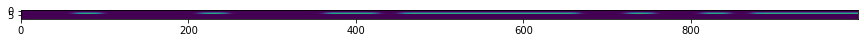

In [220]:
plt.figure(figsize = (15, 10))
plt.imshow(all_out.T[:10, 1000:2000])

In [221]:
all_out.T[3, 1000:2000]

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.00942264, 0.01325097, 0.0186055 , 0.02606656,
       0.03640861, 0.05064057, 0.07003141, 0.09609567, 0.13049925,
       0.17483739, 0.23025063, 0.29690726, 0.37349752, 0.45700301,
       0.54299699, 0.62650248, 0.70309274, 0.76974937, 0.82516261,
       0.86950075, 0.90390433, 0.92996859, 0.94935943, 0.96359

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


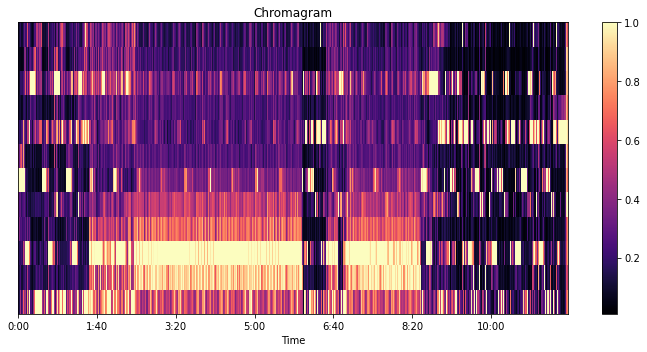

In [113]:
plt.figure(figsize = (10, 5))
librosa.display.specshow(chromagram, x_axis = "time")
plt.colorbar()
plt.title("Chromagram")
plt.tight_layout()

In [117]:
!rm ./samples/*
for _i,i in zip(trange(len(all_out)), all_out):
  i.save(f"./samples/part_g1{_i}.png")

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
100%|██████████| 900/900 [00:38<00:00, 23.28it/s]


In [120]:
!ffmpeg -framerate 30 -i ./samples/part_g1%d.png -i ./part_g1_30s.wav -vcodec libx264 ./samples/particle_g1.mp4 -y

ffmpeg version 4.4 Copyright (c) 2000-2021 the FFmpeg developers
  built with Apple clang version 12.0.5 (clang-1205.0.22.9)
  configuration: --prefix=/usr/local/Cellar/ffmpeg/4.4_2 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags= --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libbluray --enable-libdav1d --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libspeex --enable-libsoxr --enable-libzmq --enable-libzimg --disable-libjack --disable-indev=jack --enable-avresample --enable-videotoolbox
  libavutil      5

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


frame=  900 fps=334 q=-1.0 Lsize=    1935kB time=00:00:29.97 bitrate= 528.7kbits/s speed=11.1x    
video:1647kB audio:255kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 1.707478%
[libx264 @ 0x7f8564020e00] frame I:24    Avg QP:25.38  size:  4376
[libx264 @ 0x7f8564020e00] frame P:334   Avg QP:28.90  size:  2676
[libx264 @ 0x7f8564020e00] frame B:542   Avg QP:30.64  size:  1267
[libx264 @ 0x7f8564020e00] consecutive B-frames: 14.0% 11.6% 16.7% 57.8%
[libx264 @ 0x7f8564020e00] mb I  I16..4: 18.0% 54.7% 27.3%
[libx264 @ 0x7f8564020e00] mb P  I16..4: 14.8% 30.9% 11.4%  P16..4: 19.6% 12.4%  4.4%  0.0%  0.0%    skip: 6.5%
[libx264 @ 0x7f8564020e00] mb B  I16..4:  3.8%  8.6%  1.9%  B16..8: 26.8% 10.0%  2.2%  direct: 5.7%  skip:41.1%  L0:33.6% L1:37.4% BI:28.9%
[libx264 @ 0x7f8564020e00] 8x8 transform intra:55.7% inter:83.3%
[libx264 @ 0x7f8564020e00] coded y,u,v intra: 47.3% 25.7% 33.0% inter: 21.0% 12.8% 18.0%
[libx264 @ 0x7f8564020e00] i16 v,h,dc,p: 30% 40%  5% 26%
[li

/Users/yashbonde/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


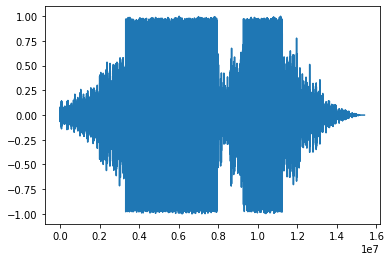

In [215]:
plt.plot(data)